# Code summarization with Anthropic Claude

## Overview

In this example, you are going to ingest text representing lines of code (String data) directly into Amazon Bedrock API (using Anthropic Claude model) and give it an instruction to summarize the respective text.


In this notebook:

1. Generate text representing code using the model
1. Use this text as input data for the model
1. The foundation model processes the input data
1. Model returns a response with the summary/explanation of the ingested text

## Setup

In [1]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57" \
    "anthropic"

  Using cached anthropic-0.21.3-py3-none-any.whl.metadata (17 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.10.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached docutils-0.16-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl.metadata (14 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached anyio-4.3.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached httpx-0.27.0-py3-none-any.whl.metadata (7.2 kB)
  Using cached pydantic-2.6.4-py3-none-any.whl.metadata (85 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached tokenizers-0.15.2-cp310

In [2]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [3]:
import json
import os
import sys

import boto3

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww

# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
# os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
# os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."


boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None)
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Code generation

Let's prepare an input for  the Amazon Bedrock service to generate python program for our use-case.

In [4]:
# create sales.csv file
import csv

data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

# Write data to sales.csv
with open('data/sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


#### Analyzing sales with Amazon Bedrock generated Python program

In [9]:
# Create the prompt
# Analyzing sales

prompt_data = """

Human: You have a CSV, data/sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, not span multiple lines unnessarily, and prefer to use standard libraries. Return only python code without any surrounding text, explanation or context.

Assistant:
"""

Let's start use the Anthropic Claude V2 model.

In [10]:
# Claude - Body
body = json.dumps({
                    "prompt": prompt_data,
                    "max_tokens_to_sample":4096,
                    "temperature":0.5,
                    "top_k":250,
                    "top_p":0.5,
                    "stop_sequences": ["\n\nHuman:"]
                  }) 

#### Invoke the Anthropic Claude v2 model

In [11]:
modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
accept = 'application/json'
contentType = 'application/json'

response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

print_ww(response_body.get('completion'))

 Here is the Python code to analyze the sales data from the CSV file:

```python
import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue = 0
monthly_revenue = defaultdict(int)
product_revenue = defaultdict(int)
max_revenue = 0
max_revenue_date = ''
max_revenue_product = ''

with open('data/sales.csv') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for row in reader:
        date, product, price, units = row
        revenue += float(price) * int(units)
        monthly_revenue[date[:7]] += float(price) * int(units)
        product_revenue[product] += float(price) * int(units)
        if float(price) * int(units) > max_revenue:
            max_revenue = float(price) * int(units)
            max_revenue_date = date
            max_revenue_product = product

print("Total revenue:", revenue)
print("Product with highest revenue:", max_revenue_product)
print("Date with highest revenue:", max_revenue_date)

months = list(monthly_revenue.keys(

#### Execute the Bedrock generated code for validation. Paste the code in below cell.

Total revenue: 35490.0
Product with highest revenue: P003
Date with highest revenue: 2023-04-23


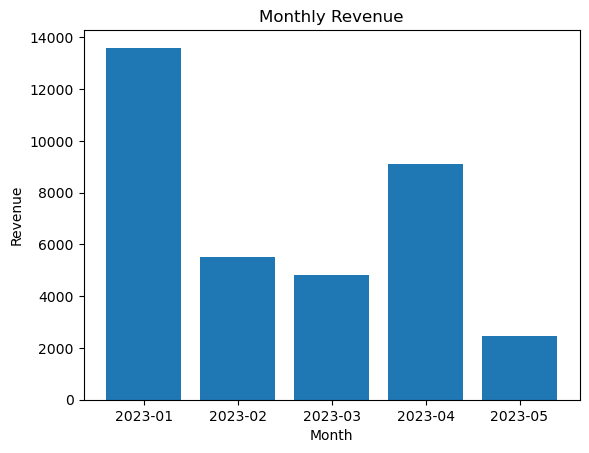

In [12]:
import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue = 0
monthly_revenue = defaultdict(int)
product_revenue = defaultdict(int)
max_revenue = 0
max_revenue_date = ''
max_revenue_product = ''

with open('data/sales.csv') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for row in reader:
        date, product, price, units = row
        revenue += float(price) * int(units)
        monthly_revenue[date[:7]] += float(price) * int(units)
        product_revenue[product] += float(price) * int(units)
        if float(price) * int(units) > max_revenue:
            max_revenue = float(price) * int(units)
            max_revenue_date = date
            max_revenue_product = product

print("Total revenue:", revenue)
print("Product with highest revenue:", max_revenue_product)
print("Date with highest revenue:", max_revenue_date)

months = list(monthly_revenue.keys())
values = list(monthly_revenue.values())

plt.bar(months, values)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Monthly Revenue")
plt.show()

Now let's build the prompt for requesting a summary, using the text we just saw

In [13]:
code_text="""import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue = 0
monthly_revenue = defaultdict(int)
product_revenue = defaultdict(int)
max_revenue = 0
max_revenue_date = ''
max_revenue_product = ''

with open('data/sales.csv') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for row in reader:
        date, product, price, units = row
        revenue += float(price) * int(units)
        monthly_revenue[date[:7]] += float(price) * int(units)
        product_revenue[product] += float(price) * int(units)
        if float(price) * int(units) > max_revenue:
            max_revenue = float(price) * int(units)
            max_revenue_date = date
            max_revenue_product = product

print("Total revenue:", revenue)
print("Product with highest revenue:", max_revenue_product)
print("Date with highest revenue:", max_revenue_date)

months = list(monthly_revenue.keys())
values = list(monthly_revenue.values())

plt.bar(months, values)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Monthly Revenue")
plt.show()"""

In [14]:
prompt = f"""

Human: Please provide an explanation of the following text. Keep in mind that the person requesting this explanation is not familiar with the topic and is looking for a high-level overview of the content. The explanation should be concise and easy to understand.
<text>
{code_text}
</text>

Assistant:"""

## Creating request body with prompt and inference parameters 

Following the request syntax of `invoke_model`, you create request body with the above prompt and inference parameters.

In [15]:
body = json.dumps({"prompt": prompt,
                 "max_tokens_to_sample":4096,
                 "temperature":0.5,
                 "top_k":250,
                 "top_p":0.5,
                 "stop_sequences":[]
                  }) 

## Invoke foundation model via Boto3

Here sends the API request to Amazon Bedrock with specifying request parameters `modelId`, `accept`, and `contentType`. Following the prompt, the foundation model in Amazon Bedrock summarizes the text.

In [16]:
modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
accept = 'application/json'
contentType = 'application/json'

response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

print_ww(response_body.get('completion'))

 This Python code is analyzing sales data from a CSV file. It is calculating total revenue, revenue
per month, revenue per product, and finding the highest revenue transaction.

It first initializes some variables to track the revenue metrics.

It then opens the sales CSV file and loops through each row, parsing the date, product, price and
units sold.

For each row, it calculates the revenue by multiplying price and units. It adds this revenue to the
total, monthly and per product revenue variables.

It also compares each transaction's revenue to the max revenue seen so far, and if it is higher it
updates the max revenue, date and product.

After processing the full CSV file, it prints out some summary revenue statistics.

It then generates a bar chart visualization of the monthly revenue data using Matplotlib.

So in summary, this is reading in sales data, performing some revenue calculations on it, and
generating a chart - aimed at analyzing the sales and revenue patterns. The metri

## Let's try with a more complex code summarization/explanation request

In [17]:
prompt = f"""

Human: Please provide an explanation of the following text. Keep in mind that the person requesting this explanation is very familiar with the topic and is looking for a low-level overview of the content.
Also provide a documentation of the code after explaining it.
<text>
{code_text}
</text>

Assistant:"""

In [18]:
body = json.dumps({"prompt": prompt,
                 "max_tokens_to_sample":4096,
                 "temperature":0.5,
                 "top_k":250,
                 "top_p":0.5,
                 "stop_sequences":[]
                  }) 

In [19]:
modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
accept = 'application/json'
contentType = 'application/json'

response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

print_ww(response_body.get('completion'))

 Here is an explanation of the code:

The code is analyzing revenue data from a CSV file called sales.csv.

It first imports the csv module to read the CSV file, collections.defaultdict to create dictionaries
with default values, and matplotlib.pyplot to generate a chart.

It initializes some variables to track revenue:

- revenue - total revenue across all sales
- monthly_revenue - a dictionary with month as key and total monthly revenue as value
- product_revenue - a dictionary with product as key and total revenue for that product as value
- max_revenue - highest revenue from a single sale
- max_revenue_date - date of highest revenue sale
- max_revenue_product - product with highest revenue sale

It opens the sales.csv file and loops through each row, splitting it into date, product, price and
units.

For each sale, it calculates the revenue by multiplying price and units. It adds this to the total
revenue and to the monthly and product revenue dictionaries.

It also tracks the maxi

### Now, you try experimenting with Summarization using LLMs!
### Try experimenting with different texts (e.g. code you found online and want to be explained and documented quickly instead of reading it all without guidance). Keep in mind that Claude v2 has a maximum token window of 100k tokens (which is pretty large), so you could even try with very long text and check how the model behaves!

In [ ]:
#Exercise